In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
%matplotlib inline


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle


In [37]:
data= pd.read_csv('data.csv')
data.shape

(17908, 21)

In [38]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [39]:
data.head()

,entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


# Feature engineering

In [6]:
data.isnull().sum()

entry_id                0
age                     0
pay_schedule            0
home_owner              0
income                  0
months_employed         0
years_employed          0
current_address_year    0
personal_account_m      0
personal_account_y      0
has_debt                0
amount_requested        0
risk_score              0
risk_score_2            0
risk_score_3            0
risk_score_4            0
risk_score_5            0
ext_quality_score       0
ext_quality_score_2     0
inquiries_last_month    0
e_signed                0
dtype: int64

In [42]:
uid  = data['entry_id']
data['employed_months'] = data['months_employed'] + data['years_employed']*12

In [43]:
X = data.drop(columns=['entry_id','e_signed','months_employed','years_employed'])
Y = data['e_signed']

In [44]:
X.head()

,age,pay_schedule,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
0,40,bi-weekly,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36
1,61,weekly,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72
2,23,weekly,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6
3,40,bi-weekly,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72
4,33,semi-monthly,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60


In [45]:
X.describe()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
count,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,43.015412,0.425173,3657.214653,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,0.690878,0.878276,0.583155,0.718252,0.623112,0.622068,6.457226,43.508320
std,11.873107,0.494383,1504.890063,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,0.090470,0.054563,0.125061,0.120697,0.139729,0.139898,3.673093,26.765085
min,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,34.000000,0.000000,2580.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640993,0.850882,0.500208,0.633708,0.521735,0.519677,4.000000,24.000000
50%,42.000000,0.000000,3260.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699561,0.881004,0.588208,0.725113,0.625944,0.622974,6.000000,36.000000
75%,51.000000,1.000000,4670.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752887,0.912608,0.672395,0.806681,0.729841,0.728940,8.000000,60.000000
max,96.000000,1.000000,9985.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,201.000000


# Visualization

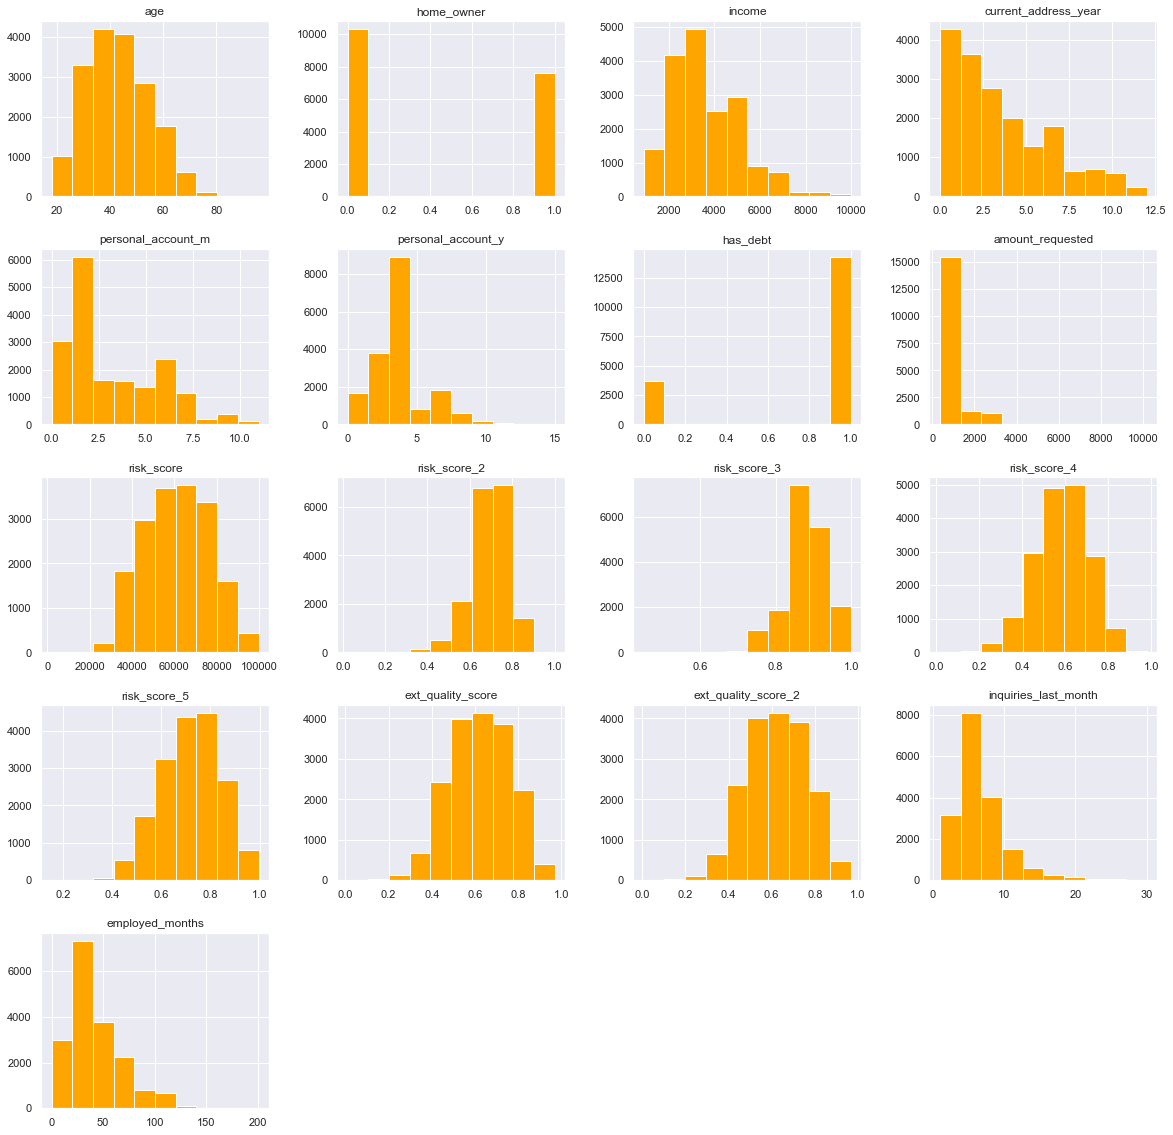

In [46]:
X.hist(figsize=(20,20),color='orange')
plt.show()


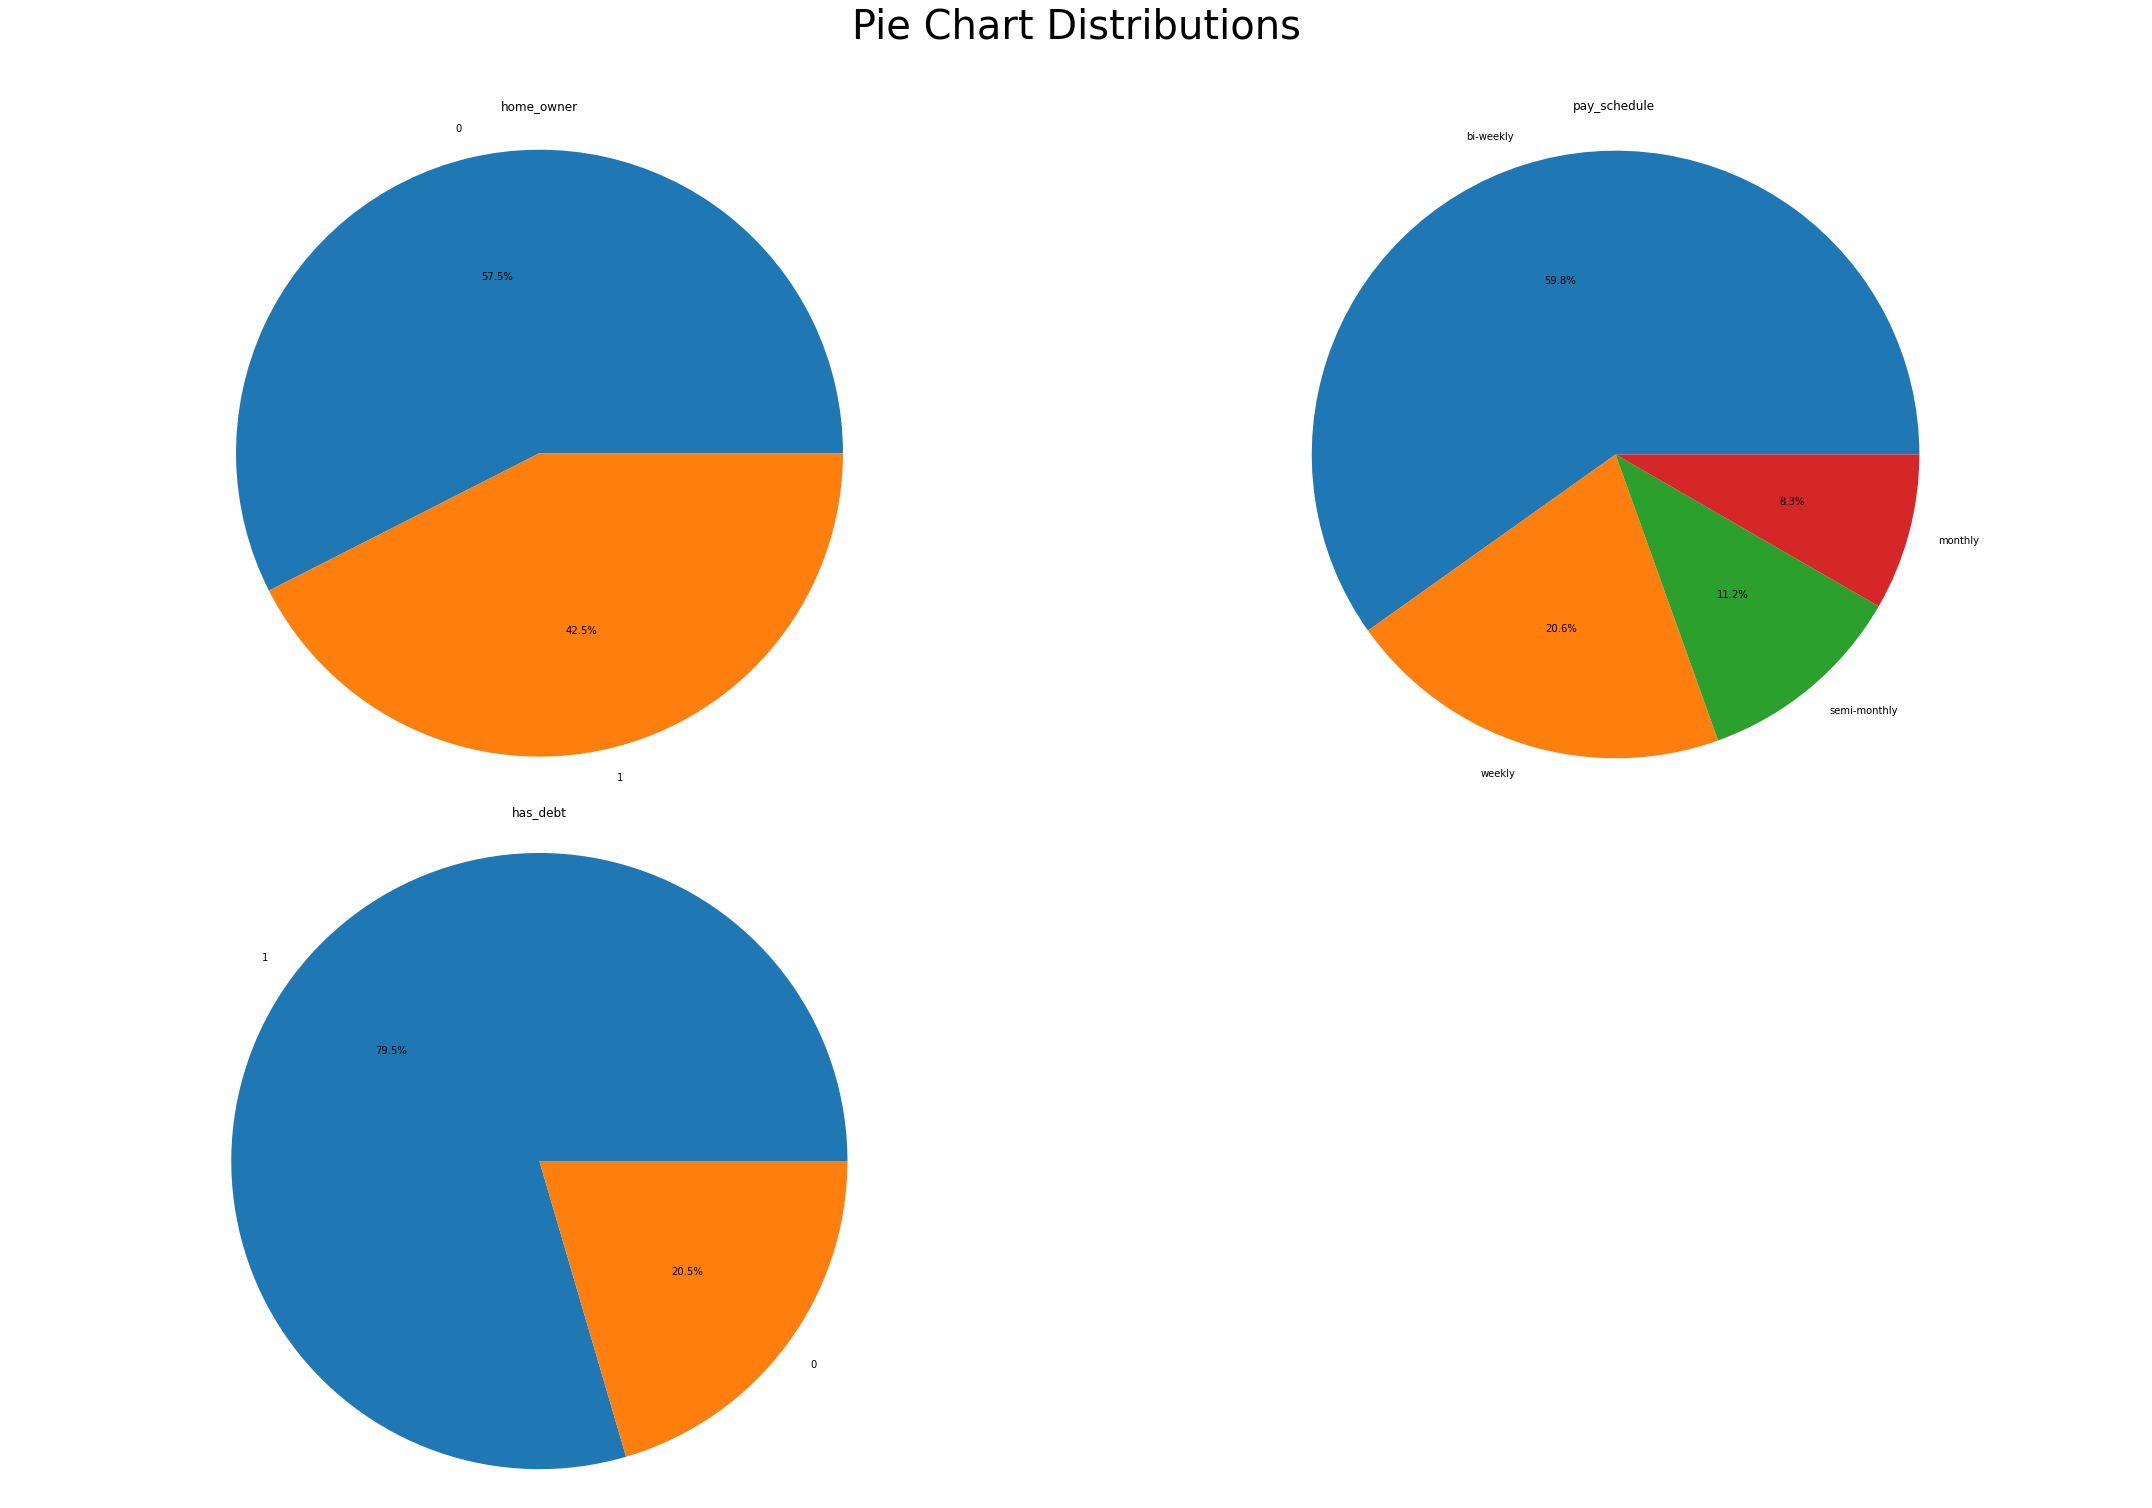

In [14]:
## Pie Plots
dataset2 = X[['home_owner', 'pay_schedule', 'has_debt']]
fig = plt.figure(figsize=(30, 22))
plt.suptitle('Pie Chart Distributions', fontsize=40)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(2, 2, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])
   
    values = dataset2.iloc[:, i - 1].value_counts(normalize = True).values
    index = dataset2.iloc[:, i - 1].value_counts(normalize = True).index
    plt.pie(values, labels = index, autopct='%1.1f%%')
    plt.axis('equal')
fig.tight_layout(rect=[0, 0.03, 1, 0.96])

<ipython-input-47-e62142ce6cdf>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

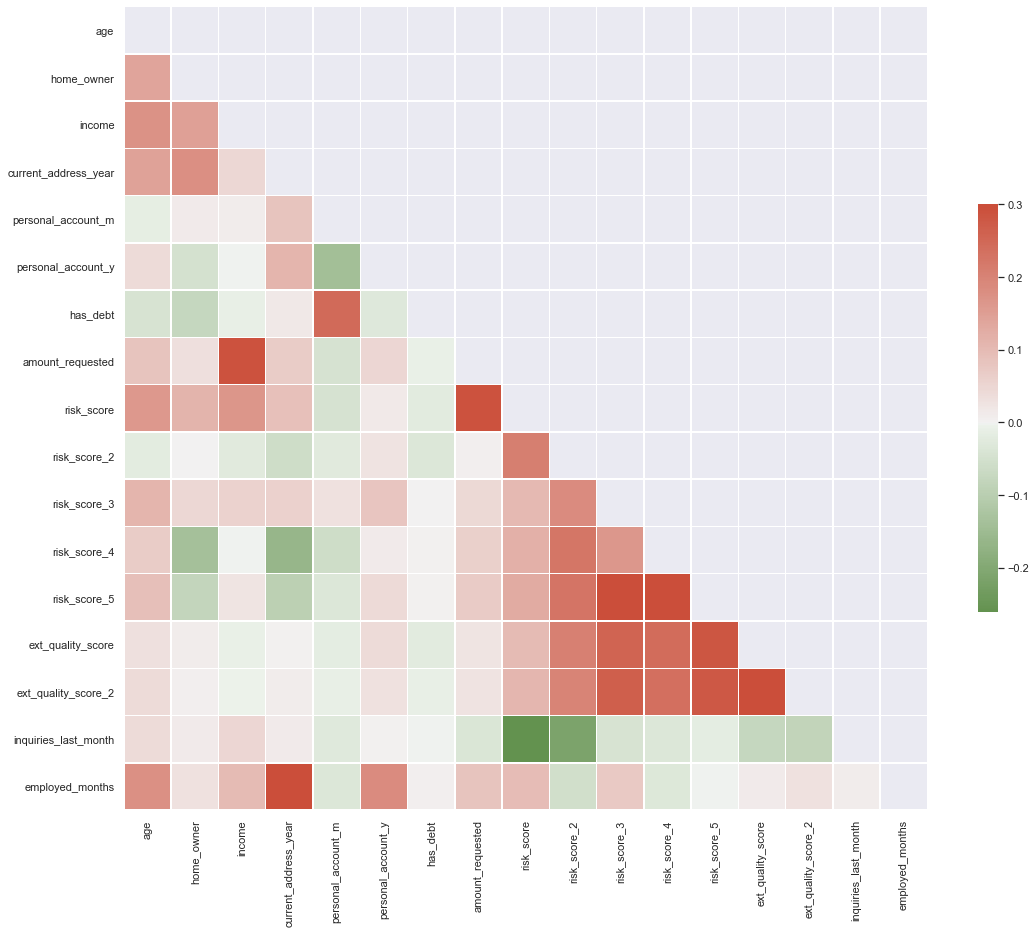

In [47]:
## Correlation Matrix
sns.set(style="dark")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 17, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
X.head()

,age,pay_schedule,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
0,40,bi-weekly,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36
1,61,weekly,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72
2,23,weekly,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6
3,40,bi-weekly,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72
4,33,semi-monthly,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60


# one-hot encoding

In [48]:

X = pd.get_dummies(X)
X.head()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
0,40,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36,1,0,0,0
1,61,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72,0,0,0,1
2,23,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6,0,0,0,1
3,40,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72,1,0,0,0
4,33,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60,0,0,1,0


In [49]:

X.drop(labels='pay_schedule_bi-weekly',inplace=True,axis=1)
col = X.columns
X.shape

(17908, 20)

# feature scaling

In [50]:
SS = StandardScaler()
X = SS.fit_transform(X)

In [51]:
X = pd.DataFrame(X)
X.columns = col
X.head()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
0,-0.253977,1.162748,-0.347022,-0.212478,1.160820,-0.768775,0.50718,-0.573275,-1.616642,0.514223,0.462623,-0.763184,-1.675935,-0.301983,-1.723802,0.964548,-0.280535,-0.301475,-0.354973,-0.509963
1,1.514775,-0.860031,-0.317118,-0.212478,-0.643926,1.788098,0.50718,-0.501696,-2.009657,0.526513,0.050418,1.041669,0.896068,0.770140,0.061845,0.692290,1.064539,-0.301475,-0.354973,1.960928
2,-1.685824,-0.860031,-1.406929,-1.302650,1.612007,-1.280150,0.50718,-0.716434,-1.723828,-0.529297,-2.047629,0.094863,0.364822,-0.654147,-0.645889,0.147774,-1.401429,-0.301475,-0.354973,1.960928
3,-0.253977,-0.860031,1.045146,-0.939260,-0.643926,1.788098,0.50718,-0.358537,-1.230123,-0.283571,1.513086,1.476706,0.501921,1.212668,-0.210989,0.420032,1.064539,-0.301475,-0.354973,-0.509963
4,-0.843561,-0.860031,-0.044665,-0.575869,-0.643926,2.299472,0.50718,0.214099,-0.470078,-0.812623,-0.379682,0.242545,-0.436878,0.869722,0.876131,1.509063,0.616181,-0.301475,2.817113,-0.509963


# Balancing the data 

In [52]:
Y.value_counts()

1    9639
0    8269
Name: e_signed, dtype: int64

In [23]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [24]:
from imblearn.over_sampling import SMOTE

In [53]:
SE = SMOTE(random_state=0)
X_resampled , Y_resample = SE.fit_resample(X,Y)
pd.Series(Y_resample).value_counts()

0    9639
1    9639
Name: e_signed, dtype: int64

In [26]:
X_resampled.shape

(19278, 20)

# Model Fitting 

In [27]:
# Functionalize model fittting

def FitModel(X,Y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2)
    
    
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
    
    
    grid_result = grid.fit(x_train, y_train)
    best_params = grid_result.best_params_
    pred = grid_result.predict(x_test)
    cm = confusion_matrix(y_test, pred)
   # metrics =grid_result.gr
    print(pred)
    #pickle.dump(grid_result,open(algo_name,'wb'))
   
    print('Best Params :',best_params)
    print('Classification Report :',classification_report(y_test,pred))
    print('Accuracy Score : ' + str(accuracy_score(y_test,pred)))
    print('Confusion Matrix : \n', cm)

# Logistic Regression

In [28]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

FitModel(X_resampled,Y_resample,'LogisticRegression_OB',LogisticRegression(),hyperparameters,cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0 1 0 ... 1 0 1]
Best Params : {'C': 1.0, 'penalty': 'l2'}
Classification Report :               precision    recall  f1-score   support

           0       0.58      0.59      0.59      1904
           1       0.59      0.58      0.59      1952

    accuracy                           0.59      3856
   macro avg       0.59      0.59      0.59      3856
weighted avg       0.59      0.59      0.59      3856

Accuracy Score : 0.5876556016597511
Confusion Matrix : 
 [[1128  776]
 [ 814 1138]]


C:\Users\ankit_aj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.57385534        nan 0.57385534        nan 0.57379048
        nan 0.57379048        nan 0.57379048        nan 0.57379048
        nan 0.57379048        nan 0.57379048        nan 0.57379048
        nan 0.57379048]
  warnings.warn(


In [29]:
 np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

# Random Forest

In [30]:
param ={
            'n_estimators': [100, 500, 1000, 2000],
           
        }
FitModel(X_resampled,Y_resample,'Random Forest_OS',RandomForestClassifier(),param,cv=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[0 0 0 ... 1 0 0]
Best Params : {'n_estimators': 500}
Classification Report :               precision    recall  f1-score   support

           0       0.67      0.71      0.69      1904
           1       0.70      0.66      0.68      1952

    accuracy                           0.68      3856
   macro avg       0.68      0.68      0.68      3856
weighted avg       0.68      0.68      0.68      3856

Accuracy Score : 0.6812759336099585
Confusion Matrix : 
 [[1344  560]
 [ 669 1283]]


# SVC

In [31]:
param ={
            'C': [0.1, 1, 100, 1000],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }
FitModel(X_resampled,Y_resample,'SVC_OS',SVC(),param,cv=3)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[0 0 0 ... 0 0 0]
Best Params : {'C': 1, 'gamma': 0.1}
Classification Report :               precision    recall  f1-score   support

           0       0.62      0.67      0.65      1904
           1       0.65      0.60      0.63      1952

    accuracy                           0.64      3856
   macro avg       0.64      0.64      0.64      3856
weighted avg       0.64      0.64      0.64      3856

Accuracy Score : 0.637707468879668
Confusion Matrix : 
 [[1281  623]
 [ 774 1178]]


# XGBoost

In [32]:
pip install xgboost

In [35]:
from xgboost import XGBClassifier
param ={
            'n_estimators': [100, 500, 1000, 2000],
            'max_depth':[2,3,4,5,6]
           
        }
FitModel(X_resampled,Y_resample,'XGBoost_OS',XGBClassifier(),param,cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\ankit_aj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 0 0 ... 0 0 0]
Best Params : {'max_depth': 2, 'n_estimators': 500}
Classification Report :               precision    recall  f1-score   support

           0       0.65      0.65      0.65      1904
           1       0.66      0.66      0.66      1952

    accuracy                           0.65      3856
   macro avg       0.65      0.65      0.65      3856
weighted avg       0.65      0.65      0.65      3856

Accuracy Score : 0.6548236514522822
Confusion Matrix : 
 [[1232  672]
 [ 659 1293]]


# LightGBM

In [56]:
pip install lightgbm

In [57]:
from lightgbm import LGBMClassifier

In [59]:

params = {}
params['learning_rate'] = [0.003,0.001,0.03,0.01,0.3,0.1]
params['max_depth'] = [5,10,15,20]
params['n_estimators']= [100, 500, 1000, 2000]

FitModel(X_resampled,Y_resample,'LightGBM_OS',LGBMClassifier(objective='binary',boosting_type='gbdt'),params,cv=5)





Fitting 5 folds for each of 96 candidates, totalling 480 fits
[0 0 0 ... 1 0 0]
Best Params : {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000}
Classification Report :               precision    recall  f1-score   support

           0       0.66      0.68      0.67      1904
           1       0.68      0.66      0.67      1952

    accuracy                           0.67      3856
   macro avg       0.67      0.67      0.67      3856
weighted avg       0.67      0.67      0.67      3856

Accuracy Score : 0.6698651452282157
Confusion Matrix : 
 [[1302  602]
 [ 671 1281]]


# CatBoost

In [60]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [61]:
from catboost import CatBoostClassifier

In [ ]:
params = {}
params['learning_rate'] = [0.003,0.001,0.03,0.01,0.3,0.1]
params['depth'] = [2,5,10,16]

FitModel(X_resampled,Y_resample,'CatBoost_OS',CatBoostClassifier(iterations=100),params,cv=5)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
